# DDPG - Deep Deterministic Policy Gradients Algorithm


In [1]:
import torch
import torch.nn as nn
import numpy as np
import mujoco_py
from matplotlib import pyplot as plt
%matplotlib inline

## DDPG structure
The algorithm consists of 4 networks. 

- Q Network
- Deterministic policy function
- target Q Network
- target policy network

Using the same principle as described in DQN, 
online networks are used for direct experiences sampled randomly from the replay buffer. 
Target networks are updated every N steps. The difference with DQN is that instead of executing hard update DDPG uses soft one.

DDPG allows to work with continues output, when vanila DQN is not suited for such task

In [2]:
import gym

# env = gym.make('Pendulum-v0')
env = gym.make('Ant-v2')
env

<TimeLimit<AntEnv<Ant-v2>>>

In [3]:
# Random agent

state = env.reset()
done = False

total_reward = 0
while not done:
    action = np.random.random_sample(env.action_space.shape[0])
    state, reward, done, _ = env.step(action)
    total_reward += reward
    env.render()

print(f'Total reward {total_reward}')
env.close()

Creating window glfw
Total reward -342.8202628957967


### Actor Network

Actor network is used for constant action on environment. 

In [4]:
import torch.nn.functional as f


class Actor(nn.Module):

    def __init__(self, inputs, outputs, hidden_layers=(128, 256)):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(inputs, hidden_layers[0])
        f1 = 1 / np.sqrt(self.fc1.weight.data.size()[0])
        nn.init.uniform_(self.fc1.weight.data, -f1, f1)
        nn.init.uniform_(self.fc1.bias.data, -f1, f1)

        self.bn1 = nn.LayerNorm(hidden_layers[0])
        self.hidden_layers = nn.ModuleList()
        self.hidden_norms = nn.ModuleList()
        for i in range(len(hidden_layers)-1):
            self.hidden_layers.append(
                nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            fn = 1 / np.sqrt(self.hidden_layers[i].weight.data.size()[0])
            nn.init.uniform_(self.hidden_layers[i].weight.data, -fn, fn)
            nn.init.uniform_(self.hidden_layers[i].bias.data, -fn, fn)
            self.hidden_norms.append(nn.LayerNorm(hidden_layers[i+1]))

        self.output = nn.Linear(hidden_layers[-1], outputs)

    def forward(self, X):
        X = f.relu(self.bn1(self.fc1(X)))
        for i in range(len(self.hidden_layers)):
            X = f.relu(self.hidden_norms[i](self.hidden_layers[i](X)))

        return torch.tanh(self.output(X))


### Critic Network

Critic network is used for criticizing Actor by soft updates every once in awhile.

In [5]:
class Critic(nn.Module):

    def __init__(self, inputs, outputs, hidden_layers=(128, 256)):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(inputs, hidden_layers[0])
        f1 = 1 / np.sqrt(self.fc1.weight.data.size()[0])
        nn.init.uniform_(self.fc1.weight.data, -f1, f1)
        nn.init.uniform_(self.fc1.bias.data, -f1, f1)

        self.bn1 = nn.LayerNorm(hidden_layers[0])
        self.hidden_layers = nn.ModuleList()
        self.hidden_norms = nn.ModuleList()
        for i in range(len(hidden_layers)-1):
            self.hidden_layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            fn = 1 / np.sqrt(self.hidden_layers[i].weight.data.size()[0])
            nn.init.uniform_(self.hidden_layers[i].weight.data, -fn, fn)
            nn.init.uniform_(self.hidden_layers[i].bias.data, -fn, fn)
            self.hidden_norms.append(nn.LayerNorm(hidden_layers[i+1]))
        self.output = nn.Linear(hidden_layers[-1], outputs)

    def forward(self, X1, X2):
        X = torch.cat([X1, X2], 1) # concatenate states and actions by columns
        X = f.relu(self.bn1(self.fc1(X)))
        for i in range(len(self.hidden_layers)):
            X = f.relu(self.hidden_norms[i](self.hidden_layers[i](X)))
        
        return self.output(X)

### Replay Buffer

Replay Buffer serves as a storage for sampling data points. Samples are drawn randomly to achieve IID - Independent and Identical Distribution

In [6]:
from collections import deque
import random

class ReplayBuffer():

    def __init__(self, cap=128):
        self.buffer = deque(maxlen=cap)

    def add(self, state, action, reward, next_state, done):
        exp = (state, action, np.array([reward]), next_state, done)
        self.buffer.append(exp)
        

    def sample(self, batch_size):
        states, actions, rewards, next_states, dones = zip(*random.sample(self.buffer, batch_size))
        return np.vstack(states), np.vstack(actions), np.vstack(rewards), np.vstack(next_states), np.vstack(dones)

    def __len__(self):
        return len(self.buffer)


## PER - Prioratized Experience Replay

To ensure better datapoints used for training PER is a recommended approach.
There are a few implementation of Replay Buffer that satisfy PER. For this demo OpenAI Segment Tree based approach was chosen.
Extracted from https://raw.githubusercontent.com/openai/baselines/master/baselines/common/segment_tree.py

In [7]:
import operator


class SegmentTree(object):
    def __init__(self, capacity, operation, neutral_element):
        """Build a Segment Tree data structure.

        https://en.wikipedia.org/wiki/Segment_tree

        Can be used as regular array, but with two
        important differences:

            a) setting item's value is slightly slower.
               It is O(lg capacity) instead of O(1).
            b) user has access to an efficient ( O(log segment size) )
               `reduce` operation which reduces `operation` over
               a contiguous subsequence of items in the array.

        Paramters
        ---------
        capacity: int
            Total size of the array - must be a power of two.
        operation: lambda obj, obj -> obj
            and operation for combining elements (eg. sum, max)
            must form a mathematical group together with the set of
            possible values for array elements (i.e. be associative)
        neutral_element: obj
            neutral element for the operation above. eg. float('-inf')
            for max and 0 for sum.
        """
        assert capacity > 0 and capacity & (capacity - 1) == 0, "capacity must be positive and a power of 2."
        self._capacity = capacity
        self._value = [neutral_element for _ in range(2 * capacity)]
        self._operation = operation

    def _reduce_helper(self, start, end, node, node_start, node_end):
        if start == node_start and end == node_end:
            return self._value[node]
        mid = (node_start + node_end) // 2
        if end <= mid:
            return self._reduce_helper(start, end, 2 * node, node_start, mid)
        else:
            if mid + 1 <= start:
                return self._reduce_helper(start, end, 2 * node + 1, mid + 1, node_end)
            else:
                return self._operation(
                    self._reduce_helper(start, mid, 2 * node, node_start, mid),
                    self._reduce_helper(mid + 1, end, 2 * node + 1, mid + 1, node_end)
                )

    def reduce(self, start=0, end=None):
        """Returns result of applying `self.operation`
        to a contiguous subsequence of the array.

            self.operation(arr[start], operation(arr[start+1], operation(... arr[end])))

        Parameters
        ----------
        start: int
            beginning of the subsequence
        end: int
            end of the subsequences

        Returns
        -------
        reduced: obj
            result of reducing self.operation over the specified range of array elements.
        """
        if end is None:
            end = self._capacity
        if end < 0:
            end += self._capacity
        end -= 1
        return self._reduce_helper(start, end, 1, 0, self._capacity - 1)

    def __setitem__(self, idx, val):
        # index of the leaf
        idx += self._capacity
        self._value[idx] = val
        idx //= 2
        while idx >= 1:
            self._value[idx] = self._operation(
                self._value[2 * idx],
                self._value[2 * idx + 1]
            )
            idx //= 2

    def __getitem__(self, idx):
        assert 0 <= idx < self._capacity
        return self._value[self._capacity + idx]


class SumSegmentTree(SegmentTree):
    def __init__(self, capacity):
        super(SumSegmentTree, self).__init__(
            capacity=capacity,
            operation=operator.add,
            neutral_element=0.0
        )

    def sum(self, start=0, end=None):
        """Returns arr[start] + ... + arr[end]"""
        return super(SumSegmentTree, self).reduce(start, end)

    def find_prefixsum_idx(self, prefixsum):
        """Find the highest index `i` in the array such that
            sum(arr[0] + arr[1] + ... + arr[i - i]) <= prefixsum

        if array values are probabilities, this function
        allows to sample indexes according to the discrete
        probability efficiently.

        Parameters
        ----------
        perfixsum: float
            upperbound on the sum of array prefix

        Returns
        -------
        idx: int
            highest index satisfying the prefixsum constraint
        """
        assert 0 <= prefixsum <= self.sum() + 1e-5
        idx = 1
        while idx < self._capacity:  # while non-leaf
            if self._value[2 * idx] > prefixsum:
                idx = 2 * idx
            else:
                prefixsum -= self._value[2 * idx]
                idx = 2 * idx + 1
        return idx - self._capacity


class MinSegmentTree(SegmentTree):
    def __init__(self, capacity):
        super(MinSegmentTree, self).__init__(
            capacity=capacity,
            operation=min,
            neutral_element=float('inf')
        )

    def min(self, start=0, end=None):
        """Returns min(arr[start], ...,  arr[end])"""

        return super(MinSegmentTree, self).reduce(start, end)


In [8]:
class PER(ReplayBuffer):
    
    def __init__(self, cap=128, alpha=0.6, batch_size=64):
        super(PER, self).__init__(cap=cap)
        self.size = 0
        self.cap = cap
        self.max_priority, self.tree_ptr = 1.0, 0
        self.alpha = alpha
        self.batch_size = batch_size
        # capacity must be positive and a power of 2.
        tree_capacity = 1
        while tree_capacity < self.cap:
            tree_capacity *= 2

        self.sum_tree = SumSegmentTree(tree_capacity)
        self.min_tree = MinSegmentTree(tree_capacity)
        
    def add(self, state, action, reward, next_state, done):
        super().add(state, action, reward, next_state, done)
        self.sum_tree[self.tree_ptr] = self.max_priority ** self.alpha
        self.min_tree[self.tree_ptr] = self.max_priority ** self.alpha
        self.tree_ptr = (self.tree_ptr + 1) % self.cap

    def sample(self, beta = 0.4):
#         states, actions, rewards, next_states, dones = zip(*random.sample(self.buffer, batch_size))
#         return np.vstack(states), np.vstack(actions), np.vstack(rewards), np.vstack(next_states), np.vstack(dones)
        assert len(self) >= self.batch_size
        assert beta > 0
        
        indices = self._sample_proportional()
        
        experiences = np.array(self.buffer)[indices]
        states, actions, rewards, next_states, dones = zip(*experiences)
        weights = np.array([self._calculate_weight(i, beta) for i in indices])
        
#         return dict(
#             obs=obs,
#             next_obs=next_obs,
#             acts=acts,
#             rews=rews,
#             done=done,
#             weights=weights,
#             indices=indices,
#         )
        return np.vstack(states), np.vstack(actions), np.vstack(rewards), np.vstack(next_states), np.vstack(dones), weights, indices


    def __len__(self):
        return self.size
        
    def update_priorities(self, indices, priorities):
        """Update priorities of sampled transitions."""
        assert len(indices) == len(priorities)

        for idx, priority in zip(indices, priorities):
            assert priority > 0
            assert 0 <= idx < len(self)

            self.sum_tree[idx] = priority ** self.alpha
            self.min_tree[idx] = priority ** self.alpha

            self.max_priority = max(self.max_priority, priority)
            
    def _sample_proportional(self):
        """Sample indices based on proportions."""
        indices = []
        p_total = self.sum_tree.sum(0, len(self) - 1)
        segment = p_total / self.batch_size
        
        for i in range(self.batch_size):
            a = segment * i
            b = segment * (i + 1)
            upperbound = random.uniform(a, b)
            idx = self.sum_tree.retrieve(upperbound)
            indices.append(idx)
            
        return indices
    
    def _calculate_weight(self, idx, beta):
        """Calculate the weight of the experience at idx."""
        # get max weight
        p_min = self.min_tree.min() / self.sum_tree.sum()
        max_weight = (p_min * len(self)) ** (-beta)
        
        # calculate weights
        p_sample = self.sum_tree[idx] / self.sum_tree.sum()
        weight = (p_sample * len(self)) ** (-beta)
        weight = weight / max_weight
        
        return weight
    
    

In [9]:
# Ornstein-Ulhenbeck Process
# Taken from #https://github.com/vitchyr/rlkit/blob/master/rlkit/exploration_strategies/ou_strategy.py
class OUNoise(object):
    def __init__(self, action_space, mu=0.0, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=100000):
        self.mu           = mu
        self.theta        = theta
        self.sigma        = max_sigma
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        self.action_dim   = action_space.shape[0]
        self.low          = action_space.low
        self.high         = action_space.high
        self.reset()
        
    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu
        
    def evolve_state(self):
        x  = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state
    
    def get_action(self, action, t=0):
        ou_state = self.evolve_state()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        return np.clip(action + ou_state, self.low, self.high)

In [10]:
class Utils:

    @staticmethod
    def soft_update(target, source, tau):
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)

    @staticmethod
    def hard_update(target, source):
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(param.data)

In [19]:
class Agent:

    def __init__(self, state_size, action_size, net_dim=(256, 256), buffer_size=50_000, batch_size=64, gamma=0.99, tau=1e-2, actor_lr=1e-4, critic_lr=1e-3, eps=1e-6, device='cpu'):
        self.actor = Actor(state_size, action_size, hidden_layers=net_dim)
        self.actor_target = Actor(
            state_size, action_size, hidden_layers=net_dim)

        self.critic = Critic(state_size + action_size,
                             action_size, hidden_layers=net_dim)
        self.critic_target = Critic(
            state_size + action_size, action_size, hidden_layers=net_dim)

        Utils.hard_update(self.actor_target, self.actor)
        Utils.hard_update(self.critic_target, self.critic)

        self.buffer = PER(cap=buffer_size, batch_size=batch_size) # ReplayBuffer(cap=buffer_size)
        self.eps = eps
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.actor_lr = actor_lr
        self.critic_lr = critic_lr
        self.criterion = nn.MSELoss()
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = optim.Adam(
            self.critic.parameters(), lr=critic_lr)

        self.device = torch.device(device)
        self.actor.to(self.device)
        self.actor_target.to(self.device)
        self.critic.to(self.device)
        self.critic_target.to(self.device)
        self.beta = 0.4

    def step(self):
        if len(self.buffer) < self.batch_size:
            return
            
        states, actions, rewards, next_states, _, weights, indices = self.buffer.sample(
            self.batch_size, beta=self.beta)
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(actions).float().to(self.device)
        rewards = torch.from_numpy(rewards).float().to(self.device)
        next_states = torch.from_numpy(next_states).float().to(self.device)
        weights = torch.from_numpy(weights).float().to(self.device).reshape(-1, 1)

        qval = self.critic.forward(states, actions)
        next_actions = self.actor_target.forward(next_states)
        nextQ = self.critic_target.forward(next_states, next_actions.detach())
        qprime = rewards + self.gamma * nextQ
        
        TD_err = qprime - qval
        w_TD_err = torch.mul(TD_err, weights)
        zero_tensor = torch.zeros(w_TD_err.shape)
#         critic_loss = self.criterion(qval, qprime)
        critic_loss = self.criterion(w_TD_err, zero_tensor)
        
        actor_loss = - \
            self.critic.forward(states, self.actor.forward(states)).mean()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        nn.utils.clip_grad_norm_(self.critic.parameters(), 1)
        self.critic_optimizer.step()

        Utils.soft_update(self.actor_target, self.actor, self.tau)
        Utils.soft_update(self.critic_target, self.critic, self.tau)
        
        loss_for_prior = TD_err.detach().cpu().numpy()
        new_priorities = np.abs(loss_for_prior) + self.eps
        self.buffer.update_priorities(indices, new_priorities)
        self.beta *= 0.9999

    @torch.no_grad()
    def get_action(self, state, target=False):
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        action = self.actor.forward(state) if not target else self.actor_target.forward(state)
        return action.cpu().detach().numpy()[0]

    def push(self, state, action, reward, next_state, done):
        self.buffer.add(state, action, reward, next_state, done)

    def save(self, path):
        torch.save(self.actor.state_dict(), path + '_actor.pth')
        torch.save(self.critic.state_dict(), path + '_critic.pth')
        torch.save(self.actor_target.state_dict(), path + '_actor_target.pth')
        torch.save(self.critic_target.state_dict(), path + '_critic_target.pth')


Using device cpu
Episode 499 reward 2.876 mean reward -102.135 beta value 0.033				

Text(0, 0.5, 'Reward')

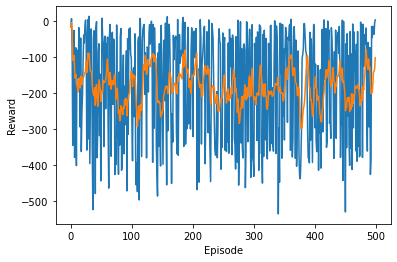

In [22]:
import torch.optim as optim

# traning routine
EPISODES = 500

# env = gym.make('InvertedDoublePendulum-v2') 
noise = OUNoise(env.action_space)

num_states = env.observation_space.shape[0]
num_actions = env.action_space.shape[0]

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Using device {device}')
agent = Agent(num_states, num_actions, buffer_size=500_000, device=device)

rewards = []
avg_rewards = []
total_steps = 0
for i in range(EPISODES):
    state = env.reset()
    noise.reset()
    ep_reward = 0
    step = 0
    while True:
        step += 1
        total_steps += 1
        action = agent.get_action(state)
        action = noise.get_action(action, step)
        next_state, reward, done, _ = env.step(action)

        # add new data to replay buffer
        agent.push(state, action, reward, next_state, done)
        if (total_steps + 1) % 20 == 0:
            for _ in range(10):
                agent.step()

        ep_reward += reward
        state = next_state
        if done:
            break

    rewards.append(ep_reward)
    avg_rewards.append(np.mean(rewards[-10:]))
    print(f'\rEpisode {i} reward {ep_reward:.3f} mean reward {avg_rewards[-1]:.3f} beta value {agent.beta:.3f}\t', end='')
    agent.beta *= 0.995
#     if avg_rewards[-1] > -250:
#         print(f'Early stop at episode {i}')
#         break
    
plt.plot(rewards)
plt.plot(avg_rewards)
plt.plot()
plt.xlabel('Episode')
plt.ylabel('Reward')

In [ ]:
# Evaluation 

total_rewards = []
for _ in range(10):
    state = env.reset()
    ep_reward = 0
    while True:
        # state = torch.from_numpy(state).float().unsqueeze(0) #.to(device)
        action = agent.get_action(state, target=True)
        next_state, reward, done, _ = env.step(action)
        ep_reward += reward
        state = next_state
        env.render()
        if done:
            break

    print(f'\rTotal reward: {ep_reward}', end='')
    total_rewards.append(ep_reward)

env.close()

plt.plot(total_rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

Creating window glfw
Total reward: 496.3639815029024

In [17]:
env.close()

In [18]:
env

<TimeLimit<AntEnv<Ant-v2>>>

In [19]:
dir(env)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_elapsed_steps',
 '_max_episode_steps',
 'action_space',
 'class_name',
 'close',
 'compute_reward',
 'env',
 'metadata',
 'observation_space',
 'render',
 'reset',
 'reward_range',
 'seed',
 'spec',
 'step',
 'unwrapped']